In [1]:
from collections import ChainMap

import numpy as np
import json
import matplotlib.pyplot as plt
import cv2

from projection import (generate_cylinder_points, 
    project_3d_to_2d, 
    draw_silhouette, 
    draw_filled_silhouette,
    compute_iou,
    cv2_imshow,
    euler_to_rotation_matrix,
    quaternion_to_rotation_matrix,
    rotation_matrix_to_euler_angles,
    jaccard_index)

from optim import optim_spsa, c_gain, a_gain

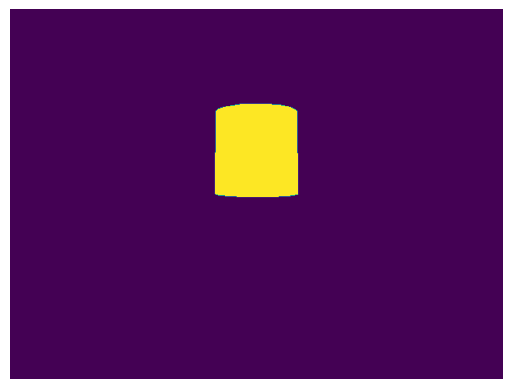

In [2]:

# Cylinder properties
radius = 1
height = 2
num_points = 50

# Camera properties
K = np.array([[800, 0, 320], [0, 800, 240], [0, 0, 1]])  # Intrinsic matrix (fx, fy, cx, cy)
R = euler_to_rotation_matrix(1.5, 0, 0) # np.eye(3)  # Identity matrix for rotation (no rotation)
t = np.array([[0, 0, 15]]).T  # Translation (keeping cylinder 5 units in front of the camera)

# Generate 3D cylinder points
cylinder_3d = generate_cylinder_points(radius, height, num_points)

# Project to 2D
cylinder_2d = project_3d_to_2d(cylinder_3d, R, t, K)

# Draw silhouette
silhouette = draw_filled_silhouette(cylinder_2d, 640, 480)

# Display using OpenCV
cv2_imshow(silhouette)

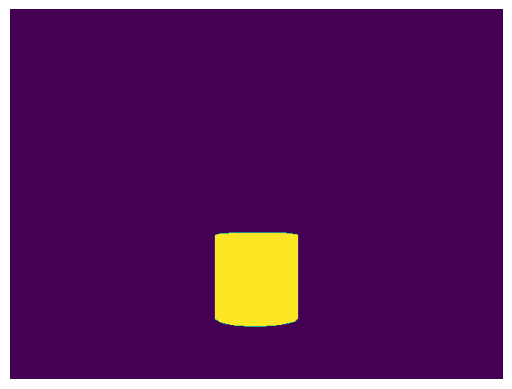

In [3]:

class Cylinder:
    def __init__(self, K, radius, height, num_points, orientation=None, position=None):
        self.K = K
        self.radius = radius
        self.height = height
        self.num_points = num_points
        self.orientation = np.array([0, 0, 0], float) if orientation is None else np.asarray(orientation)
        self.position = np.array([0, 0, 15]) if position is None else np.asarray(position)
        self.cylinder_3d = generate_cylinder_points(radius, height, num_points)
        self._R = euler_to_rotation_matrix(*self.orientation)
        self._Rkey = self.orientation.copy()

        # Camera and scene properties
        self.K = K

    def copy(self, **kwargs):
        return Cylinder(**ChainMap(kwargs, {"K": self.K.copy(), 
                  "radius": self.radius, 
                  "height": self.height,
                  "num_points": self.num_points,
                  "orientation": self.orientation.copy(),
                  "position": self.position.copy()}))

    @property
    def R(self):
        if not np.array_equal(self._Rkey, self.orientation):
            self._R = euler_to_rotation_matrix(*self.orientation)
            self._Rkey = self.orientation.copy()
        return self._R
    
    @property
    def translation(self):
        p = self.position.copy()
        p[1] -= self.height / 2
        return  np.array([p]).T

    @property
    def image_shape(self):
        return (int(self.K[0, 2] * 2), int(self.K[1, 2] * 2))

    def silhouette(self):
        cylinder_2d = project_3d_to_2d(self.cylinder_3d, self.R, self.translation, self.K)
        return draw_filled_silhouette(cylinder_2d, *self.image_shape)

    def wireframe(self):
        cylinder_2d = project_3d_to_2d(self.cylinder_3d, self.R, self.translation, self.K)
        return draw_silhouette(cylinder_2d, *self.image_shape)
    
    def plot(self, filled=False):
        mask = self.wireframe() if filled is False else self.silhouette()
        cv2_imshow(mask)
    
K = np.array([[800, 0, 320], [0, 800, 240], [0, 0, 1]])  # Intrinsic matrix (fx, fy, cx, cy)
cylinder = Cylinder(K=K, radius=1, height=2, num_points=50)
cylinder.orientation[0] += np.pi/2
cylinder.position[1] += 4
cylinder.plot()
cylinder.plot(True)

In [4]:
def create_cylinder_from_unity():
    with open('cameraData.json', 'r') as f:
        data = json.load(f)
    
    # Extract data
    f = data["K"]["f"]
    aspect_ratio = data["K"]["aspectRatio"]
    px = data["K"]["principalPoint"]["x"]
    py = data["K"]["principalPoint"]["y"]
    rotation_quaternion = [data["R"]["x"], data["R"]["y"], data["R"]["z"], data["R"]["w"]]
    t = np.array([data["t"]["x"], data["t"]["y"], data["t"]["z"]])
    cylinder_radius = data["cylinderDimensions"]["cylinderRadius"]
    cylinder_height = data["cylinderDimensions"]["cylinderHeight"]

    R = quaternion_to_rotation_matrix(rotation_quaternion)
    orientation = rotation_matrix_to_euler_angles(R)
    
    K = np.array([
        [f, 0, px],
        [0, f * aspect_ratio, py],
        [0, 0, 1]
    ])
    
    cylinder = Cylinder(K, cylinder_radius, cylinder_height, 30, np.array(orientation), t)        
    cylinder.position[1] *= -1
    cylinder.orientation[0] += np.pi / 2
    return cylinder

In [5]:
cylinder = create_cylinder_from_unity()
cylinder.image_shape

(2560, 1440)

In [6]:
cylinder.position

array([-0.31691837,  2.77999997, 11.0725565 ])

In [7]:
cylinder.orientation

array([ 1.57079633, -0.        ,  0.        ])

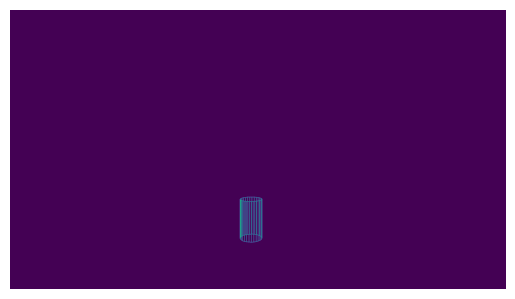

In [7]:
cylinder = create_cylinder_from_unity()
cylinder.plot()

In [10]:
mask = cylinder.silhouette()
mask.shape

(1440, 2560)

In [9]:
%%timeit
cylinder.silhouette()

438 µs ± 4.78 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


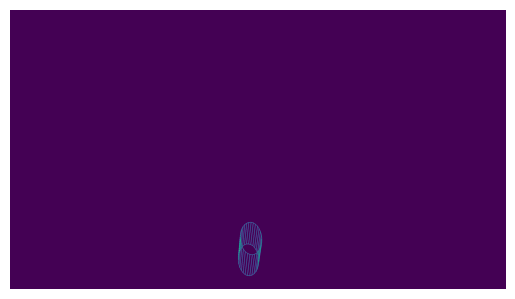

In [10]:
random_cylinder = cylinder.copy(orientation=np.random.rand(3) * 2 - 1)
random_cylinder.plot()

In [11]:
jaccard_index(cylinder.silhouette(), random_cylinder.silhouette())

0.20890915791413303

In [12]:
def loss(test_cylinder: Cylinder):
    overlap = jaccard_index(cylinder.silhouette(), test_cylinder.silhouette())
    if overlap == 0:
        return 100
    return min(-np.log(overlap), 100)

loss(random_cylinder)

1.5658557726340585

In [13]:
# theta is orientation AND position, orientation is 0, 2*np.pi, and position is -2, 2, and ...
theta_bounds = np.array([np.pi/2, np.pi, np.pi, 2, 2, 10])  # from theta_0
theta_0 = np.array([*random_cylinder.orientation, *random_cylinder.position])
c0 = theta_bounds / 20

So fixing everything except orientation is jumbled

I need to define the range of orientation values that are possible, let's just say
-np.pi/2 to np.pi/2
-np.pi to np.pi * 2

Now I want to standardize theta to scale that range to 1

And then I want to sample N points in those dim spaces, and run spsa for each until we get to a local minima

In [14]:
def get_cylinder(theta):
    bounds = np.array([np.pi, 2 * np.pi, 2 * np.pi])
    return cylinder.copy(orientation= np.asarray(theta) * bounds)
                              
def loss_norm(theta):
    return loss(get_cylinder(theta))
loss_norm(np.zeros(3))

0.871026844716998

In [15]:
optim = optim_spsa(np.zeros(3), loss_norm, a_gain(0.001, 1000), c_gain(0.001))

0.8598711044817731
0.849776859040027
0.8218723785811793
0.8132291643721644
0.8099878953015505
0.7980239032717124
0.7968451075829707
0.7887162584832861
0.7298393854702178
0.7229262095627375
0.693855232369661
0.6921030506244688
0.6897248219057557
0.6834334883723062
0.629472066198916
0.6135960153685727
0.6141662591117579
0.6091091931653271
0.6112555209536914
0.5948260807175394
0.5829812078205469
0.5647048574428939
0.5622300658860493
0.5607773194038147
0.5613131542824629
0.5389515639811572
0.5214246018710355
0.5084305640051824
0.5074877738930719
0.4954530383034952
0.5018693695465093
0.494980221817427
0.4782918501058377
0.47205714820184713
0.4730465339762042
0.4597287956413015
0.4563986678885606
0.4390980905298886
0.4279485287406332
0.4278877898232348
0.42693199843122936
0.4270301146008529
0.4271085902499923
0.4117395752432731
0.400896392590678
0.3931263046454659
0.38485702953528256
0.38541125991517505
0.3695841798156581
0.3645456429508615
0.34412822802865206
0.34095823769363626
0.336249886

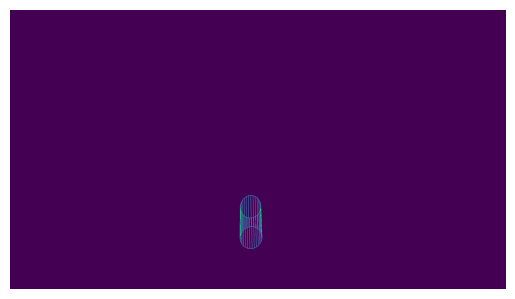

In [16]:
for i, theta in zip(range(100), optim):
    print(loss_norm(theta))
get_cylinder(theta).plot()

In [17]:
def bounding_box(mask):
    # Get the x and y coordinates of non-zero values in the mask
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def combine_bounding_boxes(bb1, bb2):
    return min(bb1[0], bb2[0]), max(bb1[1], bb2[1]), min(bb1[2], bb2[2]), max(bb1[3], bb2[3])

def get_bbox_area(bb):
    rmin, rmax, cmin, cmax = bb
    return (rmax - rmin) * (cmax - cmin)

def norm_bbox_area(mask):
    area = get_bbox_area(bounding_box(mask))
    return area / mask.size

combine_bounding_boxes(bounding_box(random_cylinder.silhouette()), bounding_box(mask))

norm_bbox_area(mask)



# 1.0 means taking up entire space AND 0 overlap
# iou = 1 when i == u, so area * (1 - iou)
# 0.0 means perfect overlap
# issue is if disappear... it penalizes being 'big'
# what if I get bbox and penalize amount of 0 inside it relative to size of the object?
# this would encourage it to get big lol, but thats ok, b/c when it gets big itll start to intersect
# and when it starts to intersect its score will go down...
# or maybe I do iterative tasking - when intersection is 0, use bounding box score, when its not, use other...
# ok I'll do that. Problem is in boundary condition... so when iou is 0, use other, but when iou approaches 1, just use that
# normalize score for both
# OR: just random select until I get a point where there is an intersection

OBJECTIVE_MASK = cylinder.silhouette()
OBJECTIVE_AREA = get_bbox_area(bounding_box(OBJECTIVE_MASK))

def calc_bbox_loss(union_mask, test_mask):
    if not np.any(test_mask):
        return 1
    rmin, rmax, cmin, cmax = bounding_box(union_mask)
    sub_array = mask[rmin:rmax+1, cmin:cmax+1]
    union_zeros = np.sum(sub_array == 0)
    
    rmin, rmax, cmin, cmax = bounding_box(test_mask)
    sub_array = mask[rmin:rmax+1, cmin:cmax+1]
    test_zeros = np.sum(sub_array == 0)
    
    # Count and return the number of zeros
    return max(0, union_zeros - test_zeros) / test_mask.size

    area = get_bbox_area(bounding_box(union_mask))
    return area / test_mask.size
    my_area = get_bbox_area(bounding_box(test_mask))
    bbox_loss = area / (my_area + OBJECTIVE_AREA) # may be > 1 or < 1 worst case is image area / their_area
    bbox_loss *= (OBJECTIVE_AREA / test_mask.size) # this scales it to be a max of 1
    # o = 90, t = 10, a = 100, f = 100
    # loss = 0.9, so loss --> 1 as 0 --> 100
    # t = 90, o = 10, a = 100, f = 100
    # loss = 0.1
    # t = 10, o = 10, a = 100, f = 100
    # 100 / 20 = 5 * 10 / 100 = 0.5
    # but if I just return area I'm guarenteed improvement from intersection is <= addition of bbox
    return bbox_loss

def better_loss(test_cylinder: Cylinder):
    test_mask = test_cylinder.silhouette()
    intersection = np.logical_and(test_mask, OBJECTIVE_MASK).sum()
    union_mask = np.logical_or(test_mask, OBJECTIVE_MASK)
    union = union_mask.sum()
    bbox_loss = calc_bbox_loss(union_mask, test_mask)
    val = 0.8 * (1 - intersection / union) + bbox_loss * 0.2
    return min(-np.log(1 - val), 100)

def get_cylinder2(theta):
    bounds = np.array([np.pi, 2 * np.pi, 2 * np.pi, 8, 8, 20])
    if theta[-1] <= 0.01:
        theta[-1] = 0.01  # clip!
    params = np.asarray(theta) * bounds
    return cylinder.copy(orientation= params[:3], position=params[3:])

def loss_norm2(theta):
    return better_loss(get_cylinder2(theta))

loss_norm2(np.random.rand(6))

1.6291225779380458

In [18]:
better_loss(cylinder.copy(orientation=[0,0,0], position=[0, 0, 2]))

1.4342319705294964

So it looks like it worked for orientation of 0... try for other orientations?

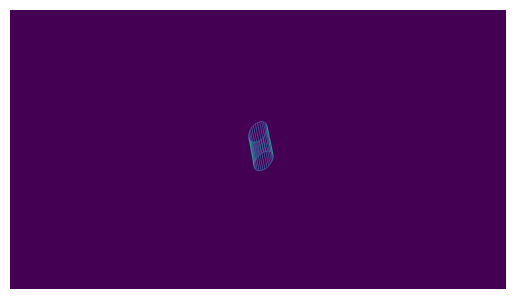

In [19]:
theta0 = np.random.rand(6)
theta0[4] = 0
theta0[3] = 0
for i in range(100):
    if loss_norm2(theta0) < 50 and theta0[-1] > 0.1:
        break
    theta0 = np.random.rand(6)
    theta0[3] = 0
    theta0[4] = 0
else:
    print("Couldnt find ok theta0?")
get_cylinder2(theta0).plot()

In [35]:
get_cylinder2(theta0).plot()
plt.gcf().savefig("output/optim_frames/frame1.png")
plt.close()
#plt.show()
N = 1_000
optim = optim_spsa(theta0, loss_norm2, a_gain(0.05, N / 5), c_gain(0.001), max_theta_diff=0.005)
for i, theta in zip(range(N), optim):
    if i % 10 == 0:
        print(loss_norm2(theta))
        get_cylinder2(theta).plot()
        num = int(i / 10) + 1
        plt.savefig(f"output/optim_frames/frame{num}.png")
        plt.close()
        #plt.show()

1.6227358460129169
1.6195266100643706
1.6157905128183763
1.614246274848933
1.612991310294896
1.6124837245996562
1.612091440779189
1.6119470255091584
1.6116544513438718
1.6109894083504366
1.6108274950785464
1.6105148810455514
1.610904101781942
1.6110024494862545
1.6110274454719546
1.611373106196898
1.6112785267668206
1.610941048956452
1.6110771676053923
1.6106112893737308
1.6104130513560266
1.6100783084160646
1.5978704109263457
1.4216538684561644
1.1919054176289638
1.0114329059682559
0.827029959572475
0.6625747606838667
0.4565558053735466
0.32928800812643955
0.15392283829956155
0.055537239068946385
0.05494310054007881
0.06285337372917117
0.06666633501874
0.043987309468660134
0.052590503328435116
0.05865083853173594
0.049656413618499984
0.06949836639777462
0.058534642555801854
0.04030942375493233
0.057404942125611966
0.06769703507388158
0.06249614632789326
0.043712342023816506
0.06621262992371721
0.0457916521550671
0.05213352326774903
0.054678391057256685
0.041297758094883535
0.062395198

In [36]:
import glob 
import os
from pathlib import Path

img_folder_path = './output/optim_frames/'

# Get the file names using glob
img_files = sorted(glob.glob(os.path.join(img_folder_path, 'frame*.png')), key=lambda s: int(Path(s).stem.replace("frame", "")))
print(img_files)

# Read the first image to get the width and height
img = cv2.imread(img_files[0])
h, w, layers = img.shape

# Define the codec using VideoWriter_fourcc and create a VideoWriter object
out = cv2.VideoWriter('output_video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 1, (w, h))

for file in img_files:
    img = cv2.imread(file)
    out.write(img)

out.release()

['./output/optim_frames\\frame1.png', './output/optim_frames\\frame2.png', './output/optim_frames\\frame3.png', './output/optim_frames\\frame4.png', './output/optim_frames\\frame5.png', './output/optim_frames\\frame6.png', './output/optim_frames\\frame7.png', './output/optim_frames\\frame8.png', './output/optim_frames\\frame9.png', './output/optim_frames\\frame10.png', './output/optim_frames\\frame11.png', './output/optim_frames\\frame12.png', './output/optim_frames\\frame13.png', './output/optim_frames\\frame14.png', './output/optim_frames\\frame15.png', './output/optim_frames\\frame16.png', './output/optim_frames\\frame17.png', './output/optim_frames\\frame18.png', './output/optim_frames\\frame19.png', './output/optim_frames\\frame20.png', './output/optim_frames\\frame21.png', './output/optim_frames\\frame22.png', './output/optim_frames\\frame23.png', './output/optim_frames\\frame24.png', './output/optim_frames\\frame25.png', './output/optim_frames\\frame26.png', './output/optim_fram

1.6217777332156134
1.621438615892187
1.621438615892187
1.6214726597258222
1.6213351187738851
1.6213246872978393
1.6211314501579384
1.620916298189566
1.6207486544466676
1.6204825674275107
1.619952524642871
1.6196740425875396
1.619456463930216
1.619102246319377
1.6190129583552257
1.6184812301603921
1.618398566620659
1.6183919976258223
1.618357511110867
1.618357511110867
1.6183301417073956
1.6183301417073956
1.6183022256875392
1.618211914491517
1.617896983805814
1.6173158127201792
1.61719633845601
1.617166540463162
1.6170544642205844
1.6169861312124894
1.6169814847374897
1.6164459181881974
1.616105326869765
1.6157727682293495
1.6155350211100943
1.615538023304562
1.6150146859392092
1.6149104877333975
1.6142697165611168
1.6142045717658833
1.6141814041378728
1.6140001700422015
1.6139334078647216
1.6137078119349542
1.6134245268172138
1.6134245268172138
1.6134245268172138
1.6133913005523386
1.6132916283811074


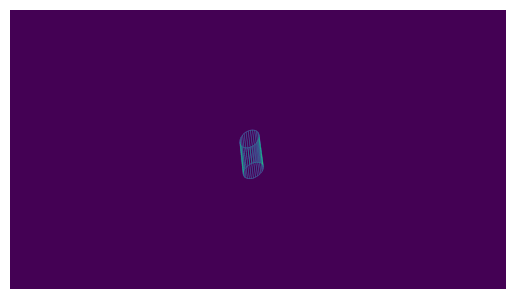

In [22]:
optim = optim_spsa(theta0, loss_norm2, a_gain(0.01, 100), c_gain(0.001))
for i, theta in zip(range(50), optim):
    if i % 50:
        print(loss_norm2(theta))
get_cylinder2(theta).plot()

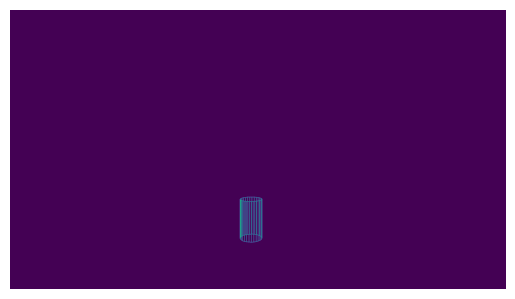

In [37]:
cylinder.plot()

In [24]:
def get_cylinder(theta):
    bounds = np.array([np.pi, 2 * np.pi, 2 * np.pi])
    return cylinder.copy(orientation= np.asarray(theta) * bounds)
                              
def loss_norm(theta):
    return loss(get_cylinder(theta))

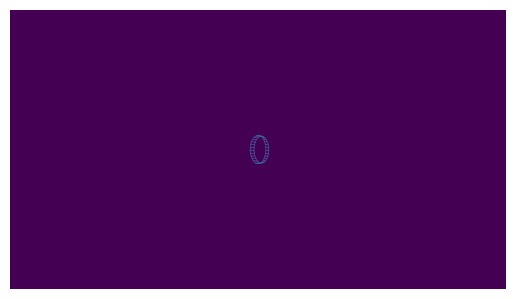

In [25]:
test_cylinder = Cylinder(cylinder.K, cylinder.radius, cylinder.height, 30)
test_cylinder.orientation = np.array([0.1, 0.2, 0.5])
cv2_imshow(test_cylinder.wireframe())

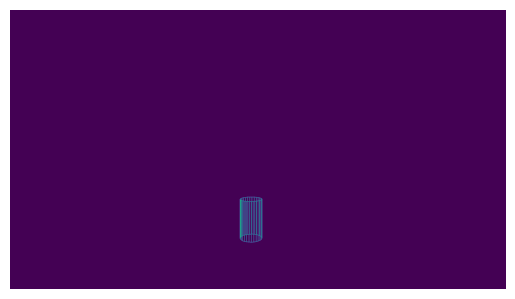

In [26]:
cv2_imshow(cylinder.wireframe())

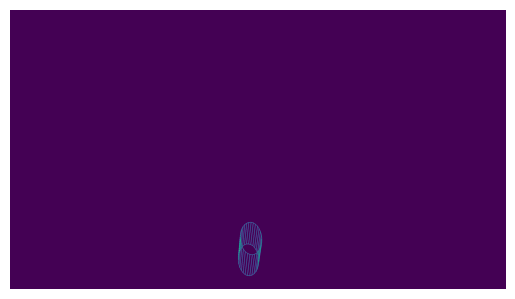

In [27]:
cv2_imshow(random_cylinder.wireframe())

In [28]:
random_cylinder.orientation

array([-0.60980197,  0.60115268,  0.87118094])

In [29]:
random_cylinder.position

array([-0.31691837,  2.77999997, 11.0725565 ])